In [1]:
import numpy as np
from modules.data_types import Transmission
from modules.emd import emd_1d
from modules.utils import get_sampling_rate
import h5py
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import pairwise_distances
from itertools import product
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import pandas as pd

In [2]:
# Open the hierarchical clustering plot data file that was saved in Mesmerize
# This is same plot as Fig 2d
t = Transmission.from_hdf5('./data/hier_clustering_all_promoters.ptrn')

In [3]:
#Open precomputed distance matrix
with h5py.File('./data/emd_dist_matrix_all_promoters_oct_20_2019.h5', 'r') as f:
    dm_emd = f['data'][()]

In [4]:
# Or recompute distance matrix, takes a while
# ~30 minutes with 64 threads on an AMD Ryzen CPU
#dm_emd = pairwise_distanceswise_distances(np.vstack(t.df._SPLICE_ARRAYS.values), metric=emd_1d, n_jobs=64)

In [5]:
# Create Euclidean Distance matrix of the data in the frequency domain
# The "_SPLICE_ARRAYS" column contains this, see corresponding analysis graph for details
dm_euc_fft = pairwise_distances(np.vstack(t.df._SPLICE_ARRAYS.values))

In [6]:
# Euclidean distance matrix of same data in the time domain
dm_euc = pairwise_distances(np.vstack(t.df._NORMALIZE.values))

# Supplementary Fig

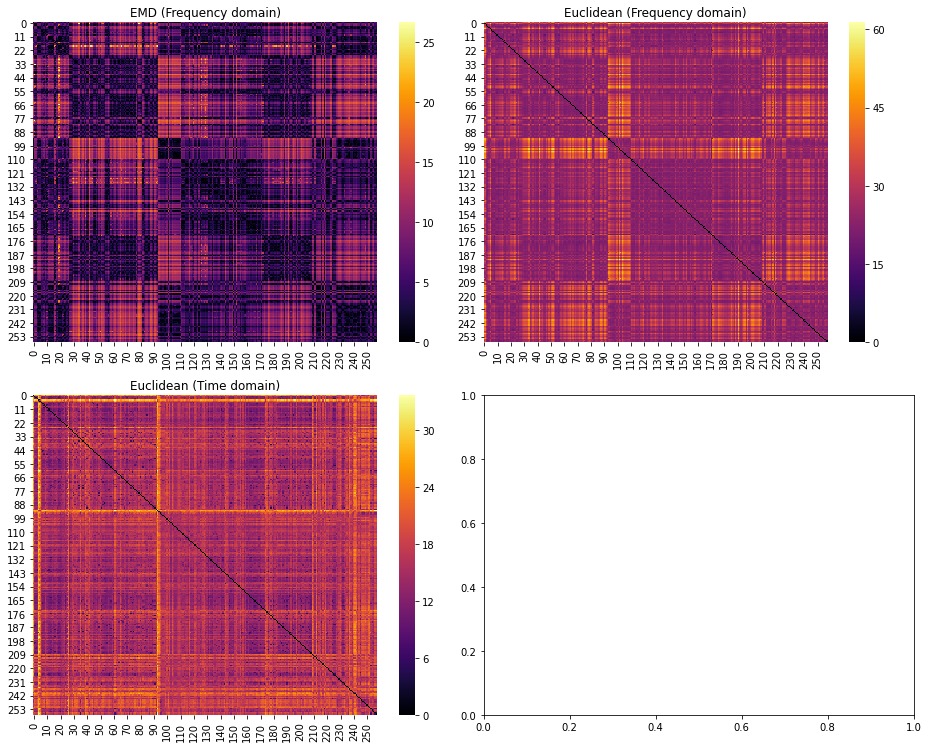

In [7]:
# Draw the distance matrices
fig = plt.figure(figsize=(2.6*5, 2.1*5))
axs = fig.subplots(nrows=2, ncols=2)
for dm, title, ax_ix in zip([dm_emd, dm_euc_fft, dm_euc], 
                            ['EMD (Frequency domain)', 'Euclidean (Frequency domain)', 'Euclidean (Time domain)'],
                            product(*(range(2), )*2)
                           ):
    
    sns.heatmap(dm, cmap='inferno', ax=axs[ax_ix])
    axs[ax_ix].set_title(title)
    
plt.tight_layout()
plt.show()

In [8]:
# Save the figure
fig.savefig('./figs/all_data_distance_matrices_comparisons.png', dpi=1200)

### The following section uses a subset of data to illustrate how EMD compares with Euclidean Distance as a metric

In [9]:
# Indices defining the data subset
# These indices correspond to the data of Fig 2d both in the paper and
# the "hier_clustering_all_promoters.ptrn" plot in the Mesmerize cell_types project
selected_curves = [191, 88, 90, 171, 11, 14,155, 157, 237, 252, 242]

In [10]:
# Time domain data
small_data = np.vstack([t.df.iloc[i]._NORMALIZE for i in selected_curves])

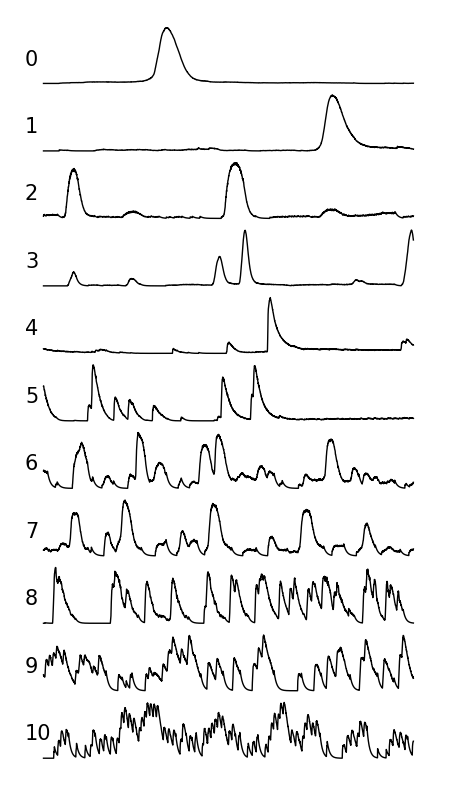

In [11]:
fig = plt.figure(figsize=(2.1, 3.9), dpi=250)
axs = fig.subplots(nrows=11, ncols=1)

for axs_ix, curve in enumerate(small_data):
    ax = axs[axs_ix]
    ax.plot(curve, c='k', linewidth=0.4)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    ax.set_title(axs_ix, loc='left', y=0, fontdict={'fontsize': 6})
    
fig.subplots_adjust(wspace=0, hspace=0.1)
plt.show()
fig.savefig('./figs/example_curves_for_dist_matrices.png', 
            dpi=1200, bbox_inches='tight', pad_inches=0)

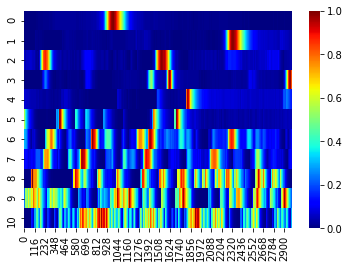

In [12]:
# Visualize the same data in the form of a heatmap
sns.heatmap(small_data, cmap='jet')

In [13]:
# Subset of frequency domain data
small_data_fft = np.vstack([t.df.iloc[i]._SPLICE_ARRAYS for i in selected_curves])

# All frequency domain data
all_rdata = np.vstack(t.df._SPLICE_ARRAYS.values)

# EMD calculation cannot use negative weights
small_data_fft += abs(all_rdata.min())

In [14]:
# Compute small EMD matrix
small_data_emd = pairwise_distances(small_data_fft, metric=emd_1d, n_jobs=22)

In [15]:
# Compute small Euclidean distance matrices

# Freq domain
small_data_euc_fft = pairwise_distances(small_data_fft, metric='euclidean')

# Time domain
small_data_euc = pairwise_distances(small_data, metric='euclidean')

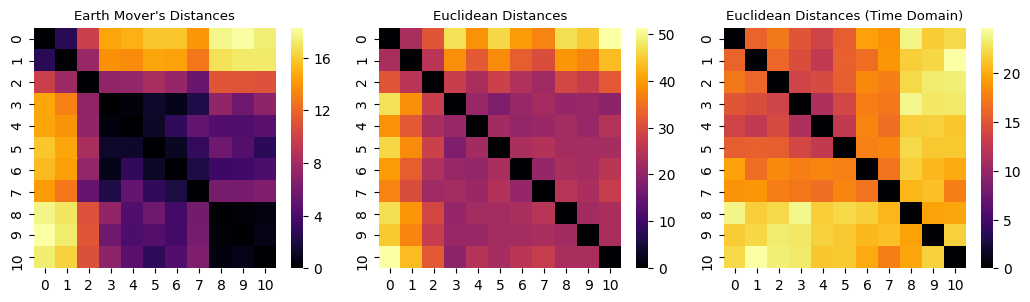

In [16]:
# Draw the small distance matrices
# fig = plt.figure(figsize=(2.8*2.5, 1.25*2.5), dpi=100)
fig = plt.figure(figsize=(3.5*3, 1.25*2.5), dpi=100)
axs = fig.subplots(nrows=1, ncols=3)
for axs_ix, (small_dm, title) in enumerate(zip([small_data_emd, small_data_euc_fft, small_data_euc],
                                               ["Earth Mover's Distances",
                                                "Euclidean Distances",
                                                "Euclidean Distances (Time Domain)"])):
    ax = axs[axs_ix]
    sns.heatmap(small_dm, cmap='inferno', ax=ax)
    ax.set_title(title, fontdict={'fontsize': 9.5})
fig.tight_layout()


In [17]:
fig.savefig('./figs/distance_matrices_comparisons.png', dpi=1200, 
            bbox='tight', pad_inches=0)

In [18]:
# Compute linkages for all these distance matrices to draw a dendrogram
linkage_emd = hierarchy.linkage(y=squareform(small_data_emd, checks=False), method='complete', optimal_ordering=True)
linkage_euc_fft = hierarchy.linkage(y=squareform(small_data_euc_fft, checks=False), method='complete', optimal_ordering=True)
linkage_euc = hierarchy.linkage(y=squareform(small_data_euc, checks=False), metric='euclidean', method='complete', optimal_ordering=True)

In [19]:
# Adapted from the navis package:
# https://github.com/schlegelp/navis/blob/d1da4666464988f60a056bc767bfcc3ef943ef43/navis/clustering/cluster.py#L683
def calc_agg_coeff(lkg: np.ndarray) -> float:
    """
    Calculate the agglomerative coefficient.

    This measures the clustering structure of the linkage matrix. Because
    it grows with the number of observations, this measure should not be
    used to compare datasets of very different sizes.

    For each observation i, denote by m(i) its dissimilarity to the first
    cluster it is merged with, divided by the dissimilarity of the merger
    in the final step of the algorithm. The agglomerative coefficient is
    the average of all 1 - m(i).
    
    Parameters
    ----------
    lkg: np.ndarray
        Linkage matrix returned from scipy.cluster.hierarchy.linkage
    
    Returns
    -------
    float
        Agglomerative Coefficient
    
    """
    # Turn into pandas DataFrame for fancy indexing
    Z = pd.DataFrame(lkg, columns=['obs1', 'obs2', 'dist', 'n_org'])
    
    leaves = hierarchy.leaves_list(lkg)

    # Get all distances at which an original observation is merged
    all_dist = Z[(Z.obs1.isin(leaves)) | (Z.obs2.isin(leaves))].dist.values

    # Divide all distances by last merger
    all_dist /= lkg[-1][2]

    # Calc final coefficient
    coeff = np.mean(1 - all_dist)

    return coeff

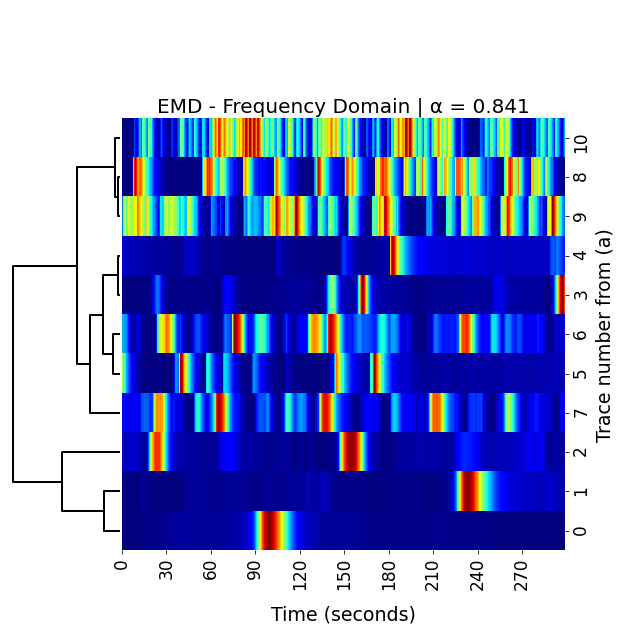

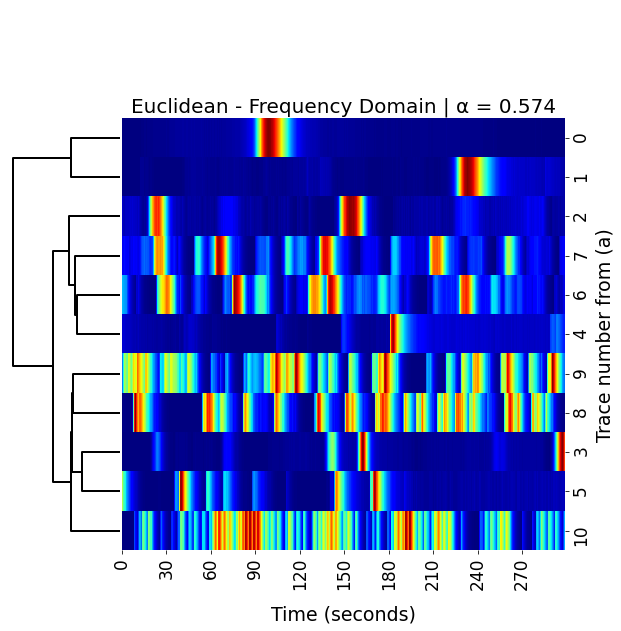

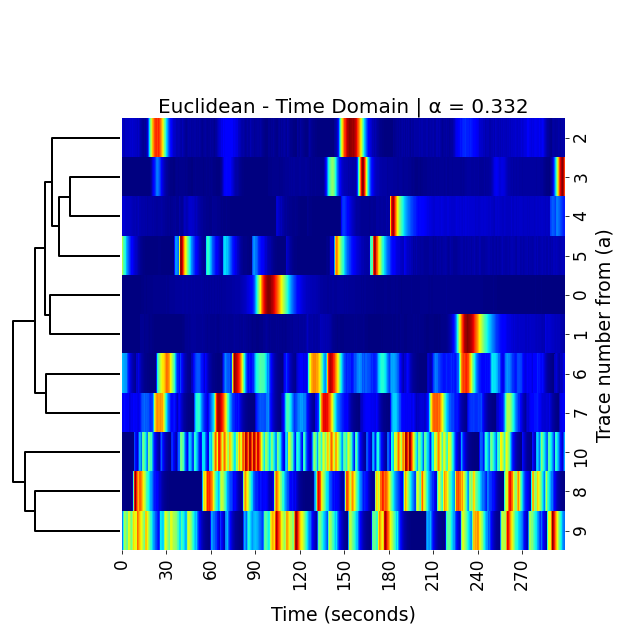

In [20]:
# For calculating xtick labels
frames_length = small_data.shape[1]
sampling_rate = get_sampling_rate(t)

# Show xticks at 30 sec intervals
xticks_interval = 30

# Recording time in seconds
recording_time = int(frames_length / sampling_rate)

dms = [linkage_emd, linkage_euc_fft, linkage_euc]

titles = \
[
    f"EMD - Frequency Domain | α = {calc_agg_coeff(linkage_emd):.3f}",
    f"Euclidean - Frequency Domain | α = {calc_agg_coeff(linkage_euc_fft):.3f}",
    f"Euclidean - Time Domain | α = {calc_agg_coeff(linkage_euc):.3f}"
]


for Z, title in zip(dms, titles):
    clustermap = sns.clustermap(small_data, row_linkage=Z, row_cluster=True, col_cluster=False, cmap='jet')
    
    clustermap.ax_heatmap.set_title(title, fontdict={'fontsize': 20})
    
    clustermap.ax_heatmap.set_xticks(np.arange(0, frames_length, xticks_interval * sampling_rate))
    clustermap.ax_heatmap.set_xticklabels(np.arange(0, recording_time, xticks_interval), fontdict={'fontsize': 17})
    
    ytl = clustermap.ax_heatmap.get_yticklabels()
    clustermap.ax_heatmap.set_yticklabels(ytl, fontdict={'fontsize': 17})
    
    clustermap.ax_heatmap.set_xlabel('Time (seconds)', fontdict={'fontsize': 19}, labelpad=15)
    clustermap.ax_heatmap.set_ylabel('Trace number from (a)', fontdict={'fontsize': 19}, labelpad=5)
    
    clustermap.cax.set_visible(False)
    
    for a in clustermap.ax_row_dendrogram.collections:
        a.set_linewidth(2)
    
    clustermap.savefig(f'./figs/{title}.png', dpi=1200, pad_inches=0, bbox_inches='tight')